# Practical Session DQN

In this practical session, you will implement the famous DQN algorithm and test it in various environments.

Run the following two cells if you are using Google Colab.

In [ ]:
!pip install gymnasium
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... done


In [ ]:
import gymnasium as gym

In [ ]:
import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def display_trajectory(frames, fps=25):
  imageio.mimwrite('./lunar_lander.gif',
                [np.array(frame) for i, frame in enumerate(frames)],
                fps=fps)
  return(Image(open('lunar_lander.gif','rb').read()))

# Lunar Lander
[Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) is a reinforcement learning toy environment provided with the Gym Library.  
In this environment, you control the reactors of a Lander that tries to land inside a landing area as smoothly as possible.
The official environment description is  
*Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.*

The environment will provide observations to the agent in the form of an 8-dimensional vector composed of:
* Position X
* Position Y
* Velocity X
* Velocity Y
* Angle
* Angular Velocity
* Is left leg touching the ground: 0 OR 1
* Is right leg touching the ground: 0 OR 1  

The agent can choose between four discrete actions:
* 0 = Do Nothing
* 1 = Fire Left Engine
* 2 = Fire Main Engine
* 3 = Fire Right Engine  

At every transition, the agent will be rewarded by the environment according to the following reward function:

* [100, 140] points for Moving to the landing pad and zero speed
* Negative reward for moving away from the landing pad
* If the lander crashes or comes to rest, it gets -100 or +100
* Each leg with ground contact gets +10
* Firing the main engine is -0.3 per frame
* Firing the side engine is -0.03 per frame
* 200 points for solving the environment




In [ ]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from IPython.display import Image
from tqdm.notebook import tqdm

In [ ]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")

In [ ]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


Here is a little code snippet to visualise a random agent playing Lunar Lander

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


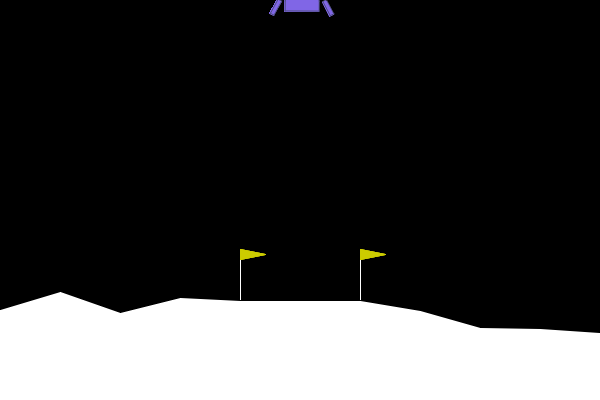

In [ ]:
images = []
obs = env.reset()
img = env.render()

while True:
    # At each step, append an image to list
    images.append(img)
    action = env.action_space.sample()
    obs, _, done, _ ,_ = env.step(action)
    img = env.render()
    if done:
        break

env.close()

display_trajectory(images)

We will now implement and train a DQN agent.
Fill the following code to create a neural network class that our agent will use.
The network should be small enough not to slow down the training process.  
You can use a two hidden layers neural network with 512 and 256 hidden neurons using a ReLU activation function and a final layer with as many neurons as the environment action space using a linear activation function.

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

The following class implements a replay buffer that will act as our agent memory.

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        """
        Replay memory allow agent to record experiences and learn from them

        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        """
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self):
        """
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors
        """
        experiences = random.sample(self.memory, k=self.batch_size)

        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# DQN
The fllowing class implements a DQN agent.  
Its training procedure is located in the `train` method.  
Fill the missing parts of the `act` and `learn` methods according to the DQN algorithm:
![](https://github.com/DavidBert/N7-techno-IA/blob/master/code/reinforcement_learning/images/dqn.png?raw=1)

In [ ]:
LR = 1e-3               # Q Network learning rate
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01  #min Epsilon

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def print_running_mean(training_rewards):
    clear_output(wait=True)
    plt.figure(figsize=(15,3))
    plt.plot(pd.Series(training_rewards).rolling(10).mean())
    plt.title("Rewards running mean on last 100 episodes")
    plt.show()

class DQNAgent:
    def __init__(self, env, gamma=0.99, memory_size=100000, batch_size=256, update_rate=4):
        self.env =  env
        self.gamma = gamma
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.update_rate = 4
        self.batch_size = batch_size
        self.q_network = QNetwork(self.state_size, self.action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001, weight_decay=1e-6)
        # Initiliase memory
        self.memory = ReplayBuffer(memory_size, batch_size)
        self.timestep = 0
        self.epsilon = 1


    def train(self, max_steps):
        self.timestep = 0
        self.epsilon = 1

        state, _ = self.env.reset()
        current_reward = 0
        episode_rewards = []
        for _ in range(max_steps):
            action = self.act(state, train=True)
            next_state, reward, done, _, info = self.env.step(action)
            current_reward += reward
            self.memory.add(state, action, reward, next_state, done)
            self.timestep += 1
            if (self.timestep % self.update_rate == 0) & (len(self.memory) > self.batch_size):
                self.learn()

            self.epsilon = max(self.epsilon * EPS_DECAY, EPS_MIN)
            if done:
                state, _ = self.env.reset()
                episode_rewards.append(current_reward)
                current_reward = 0

            else:
                state = next_state
            if self.timestep % 1000 == 0:
                print_running_mean(episode_rewards)


    def learn(self):
        experiences_batch = self.memory.sample()
        states, actions, rewards, next_states, dones = experiences_batch
        # Get the action with max Q value
        action_values = self.q_network(next_states).detach()
        max_action_values = action_values.max(1)[0].unsqueeze(1)

        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (self.gamma * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def act(self, state, train=False):

        if (random.uniform(0, 1) < self.epsilon) & train:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.q_network(state)
            action = np.argmax(action_values.cpu().data.numpy())
            return action

Instanciate a DQN agent and train it on lunar lander for at least 100000 steps

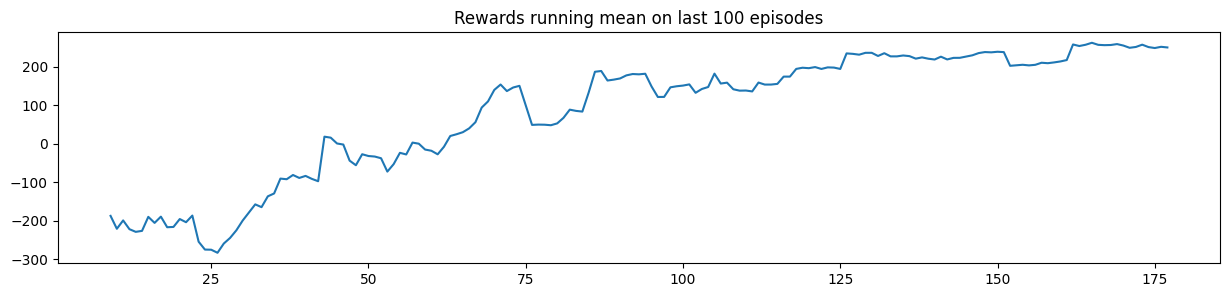

In [ ]:
dqn_agent = DQNAgent(env)
dqn_agent.train(100000)

Complete the following code to visualize your agent playing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


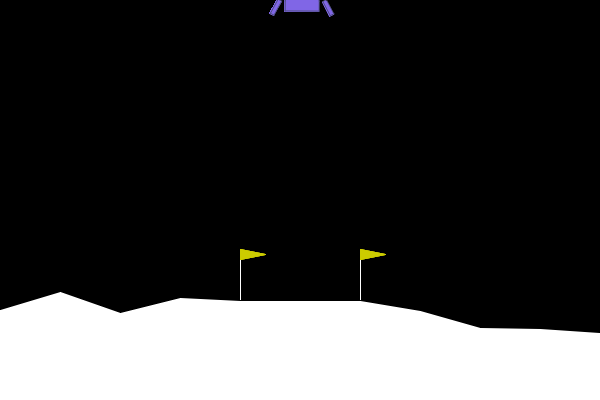

In [ ]:
obs, _ = env.reset()
img = env.render()

while True:
    # At each step, append an image to list
    images.append(img)
    action = dqn_agent.act(obs)
    obs, _, done,_ ,_ = env.step(action)
    img = env.render()
    if done:
        break

display_trajectory(images)

An important impovement of DQN is the use of a target network.  
Modify your DQN agent to use a secondary target network.  
![](https://github.com/DavidBert/N7-techno-IA/raw/master/code/reinforcement_learning/images/dqn_target.png)

In [ ]:
class DQNTargetAgent(DQNAgent):
    def __init__(self, env, gamma=0.99, memory_size=100000, batch_size=256, update_rate=4, target_update_rate=1000):
        super().__init__(env, gamma, memory_size, batch_size, update_rate)
        self.target_update_rate = target_update_rate
        self.target_network = QNetwork(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

    def learn(self):
        experiences_batch = self.memory.sample()
        states, actions, rewards, next_states, dones = experiences_batch
        # Get the action with max Q value
        action_values = self.target_network(next_states).detach()
        max_action_values = action_values.max(1)[0].unsqueeze(1)

        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (self.gamma * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.timestep % self.target_update_rate == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())


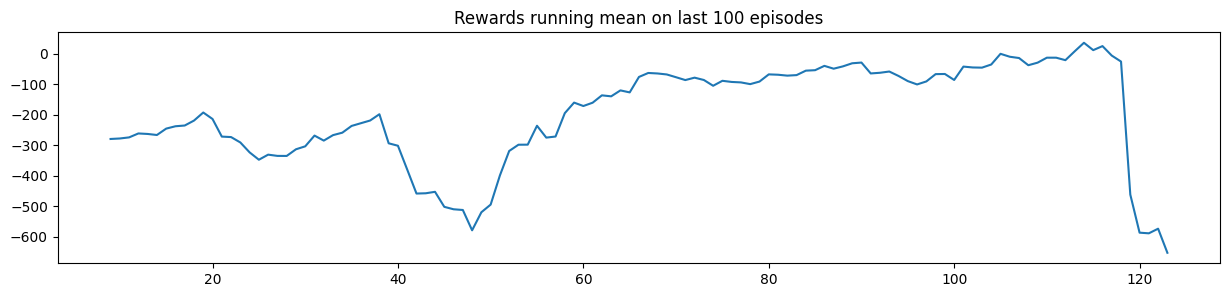

In [ ]:
dqn_target_agent = DQNTargetAgent(env, target_update_rate=1000)
dqn_target_agent.train(100000)

Visualize your agent playing.

In [ ]:
obs, _ = env.reset()
img = env.render()

while True:
    # At each step, append an image to list
    images.append(img)
    action = dqn_target_agent.act(obs)
    obs, _, done, _ ,_ = env.step(action)
    img = env.render()
    if done:
        break

env.close()
display_trajectory(images)

The following code compares all the agents.

In [ ]:
max_episodes = 100

df = pd.DataFrame(columns=['rewards', 'agent'])
random_fcn = lambda x: np.random.choice(env.action_space.n)
dqn_fcn = lambda x: dqn_agent.act(x)
target_dqn_fcn = lambda x: dqn_target_agent.act(x)

for agent, fcn in zip(['random', 'dqn', 'target_dqn'], [random_fcn, dqn_fcn, target_dqn_fcn]):
    scores = []
    for i in tqdm(range(max_episodes)):
        state = env.reset()
        score = 0
        while True:
            action = fcn(state)
            state, reward, done,_ , info = env.step(action)
            score += reward
            if done:
                break

        scores.append(score)
    for score in scores:
        df = df.append({'rewards': score, 'agent': agent}, ignore_index=True)

sns.boxplot(x="agent", y="rewards",data=df)

# Cartpole

CartPole is another [toy control environment avalible in OpeAI Gym](https://gym.openai.com/envs/CartPole-v0/).
*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.*

It is also known as the inverted pendulum problem.  
In this environment the objective is to balance a pole as long as possible. It is assumed that at the tip of the pole, there is an object which makes it unstable and very likely to fall over. The agent controls the cart and must move left and right so that the pole can stand as long as possible.

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

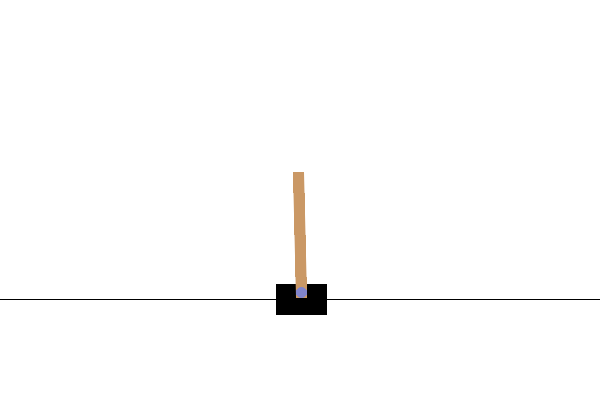

In [ ]:
images = []
obs, _ = env.reset()
img = env.render()

while True:
    # At each step, append an image to list
    images.append(img)
    action = env.action_space.sample()
    obs, _, done, _,_ = env.step(action)
    img = env.render()
    if done:
        break

env.close()
display_trajectory(images)

Train a dqn agent to solve cartpole.

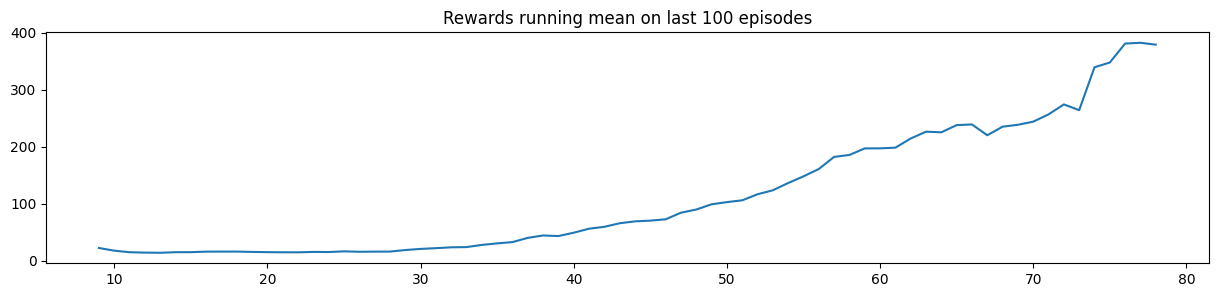

In [ ]:
dqn_agent = DQNAgent(env)
dqn_agent.train(10000)

In [ ]:
obs, _ = env.reset()
img = env.render()

while True:
    # At each step, append an image to list
    images.append(img)
    action = dqn_agent.act(obs)
    obs, _, done, _,_ = env.step(action)
    img = env.render()
    if done:
        break

env.close()
display_trajectory(images)

Train a dqn agent to solve cartpole using target network and compare its performances with the simple DQN.

In [ ]:
dqn_target_agent = DQNTargetAgent(env, target_update_rate=500)
dqn_target_agent.train(10000)

In [ ]:
obs, _ = env.reset()
img = env.render()

while True:
    # At each step, append an image to list
    images.append(img)
    action = dqn_target_agent.act(obs)
    obs, _, done, _,_ = env.step(action)
    img = env.render()
    if done:
        break

env.close()
display_trajectory(images)

In [ ]:
max_episodes = 100

df = pd.DataFrame(columns=['rewards', 'agent'])
random_fcn = lambda x: np.random.choice(env.action_space.n)
dqn_fcn = lambda x: dqn_agent.act(x)
target_dqn_fcn = lambda x: dqn_target_agent.act(x)

for agent, fcn in zip(['random', 'dqn', 'target_dqn'], [random_fcn, dqn_fcn, target_dqn_fcn]):
    scores = []
    for i in tqdm(range(max_episodes)):
        state, _ = env.reset()
        score = 0
        while True:
            action = fcn(state)
            state, reward, done, _, info = env.step(action)
            score += reward
            if done:
                break

        scores.append(score)
    for score in scores:
        df = df.append({'rewards': score, 'agent': agent}, ignore_index=True)

sns.boxplot(x="agent", y="rewards",data=df)

# Stable-baselines3

Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It contains efficient implementations of the most famous RL algorithm and is certainly one of the most simple way to prototype an RL agent.  
A full description of the librairy is available [here](https://stable-baselines3.readthedocs.io/en/master/).

In [ ]:
!pip install stable-baselines3[extra]

Help yourself with the official documentation and train a dqn agent using Stable baselines3 on Lunar lander.

In [ ]:
import gym

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = DQN('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=int(2e5))
# Save the agent
model.save("dqn_lunar")
del model  # delete trained model to demonstrate loading

# Load the trained agent
model = DQN.load("dqn_lunar", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()

In [ ]:

scores = []
for i in tqdm(range(max_episodes)):
    state = env.reset()
    score = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        state, reward, done, info = env.step(action)
        score += reward
        if done:
            break

    scores.append(score)
for score in scores:
    df = df.append({'rewards': score, 'agent': 'stable_baseline'}, ignore_index=True)

sns.boxplot(x="agent", y="rewards",data=df)

In [ ]:
obs = env.reset()
img = env.render(mode='rgb_array')

while True:
    # At each step, append an image to list
    images.append(img)
    action, _states = model.predict(obs, deterministic=True)
    obs, _, done ,_ = env.step(action)
    img = env.render(mode='rgb_array')
    if done:
        break

env.close()
imageio.mimwrite('./stable_baselines.gif',
                [np.array(img) for i, img in enumerate(images) if i%2 == 0],
                fps=29)

Image(open('stable_baselines.gif','rb').read())